In [1]:
import os
import gc
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import netCDF4 as nc
from datetime import datetime, timedelta
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as mticker
from copy import deepcopy

In [2]:
# To use PLUMBER2_GPP_common_utils, change directory to where it exists
os.chdir('/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2')
from PLUMBER2_VPD_common_utils import *

# Check data quality contral

In [9]:
# Read quality contral file
file_name = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_Qh_Rnet_quality_control_all_sites.csv" 
Qle_Qh_qc_input       = pd.read_csv(file_name,usecols=['site_name','Qle_Qh_qc'])
Qle_Qh_Rnet_qc_input  = pd.read_csv(file_name,usecols=['site_name','Qle_Qh_Rnet_qc'])

In [10]:
print(np.sum(Qle_Qh_qc_input['Qle_Qh_qc']<=2))

15762430


In [11]:
print(np.sum(Qle_Qh_Rnet_qc_input['Qle_Qh_Rnet_qc']<=2))

14249075


In [12]:
mask = (Qle_Qh_qc_input['Qle_Qh_qc']<=2) & np.isnan(Qle_Qh_Rnet_qc_input['Qle_Qh_Rnet_qc'])
Qle_Qh_Rnet_qc_input[mask]

,site_name,Qle_Qh_Rnet_qc
5,AR-SLu,NaN
29,AR-SLu,NaN
74,AR-SLu,NaN
75,AR-SLu,NaN
82,AR-SLu,NaN
...,...,...
17126689,ZM-Mon,NaN
17127217,ZM-Mon,NaN
17127410,ZM-Mon,NaN
17130817,ZM-Mon,NaN


In [13]:
mask = (Qle_Qh_Rnet_qc_input['Qle_Qh_Rnet_qc']<=2) & np.isnan(Qle_Qh_qc_input['Qle_Qh_qc'])
Qle_Qh_qc_input[mask]

,site_name,Qle_Qh_qc


#### Conclusion: there are 1513355 data points whose Qh and Qle can meet quailty contral requirement but Rnet cannot.

# Check EF between models and obs

In [27]:
model_names = ['CABLE', 'CABLE-POP-CN',
               'CHTESSEL_Ref_exp1', 'CLM5a', 'GFDL',
               'JULES_GL9', 'JULES_GL9_withLAI',
               'MATSIRO', 'MuSICA', 'NASAEnt',
               'NoahMPv401', 'ORC2_r6593',
               'ORC3_r8120', 'QUINCY',
               'STEMMUS-SCOPE','obs','all_model_same'] 
model_colors = {
                'obs': 'black',
                'CMIP6':'firebrick',
                'CABLE':'darkblue',
                'CABLE-POP-CN':'blue',
                'CHTESSEL_ERA5_3':'coral',
                'CHTESSEL_Ref_exp1':'cornflowerblue',
                'CLM5a':'deepskyblue',
                'GFDL':'c',
                'JULES_GL9':'aquamarine',
                'JULES_GL9_withLAI':'yellowgreen',
                'JULES_test':'forestgreen',
                'LPJ-GUESS':'darkolivegreen',
                'MATSIRO':'forestgreen',
                'MuSICA':'lime',
                'NASAEnt':'gold' , # 'yellow'
                'NoahMPv401':'orange' ,
                'ORC2_r6593':'pink',#'limegreen'
                'ORC2_r6593_CO2':'pink',
                'ORC3_r7245_NEE':'red',
                'ORC3_r8120':'deeppink',
                'QUINCY':'mediumorchid',
                'SDGVM': 'darkviolet',
                'STEMMUS-SCOPE':'purple',# ,
                'all_model_same':'skyblue'
                }

## Check hourly/half-hourly EF

In [53]:
file_name = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_all_sites.csv"
EF_input  = pd.read_csv(file_name, usecols=
                       ['obs_SWdown','CABLE_EF', 'CABLE-POP-CN_EF', 'CHTESSEL_Ref_exp1_EF', 'CLM5a_EF', 'GFDL_EF',
                       'JULES_GL9_EF', 'JULES_GL9_withLAI_EF', 'MATSIRO_EF', 'MuSICA_EF', 'NASAEnt_EF',
                       'NoahMPv401_EF', 'ORC2_r6593_EF', 'ORC3_r8120_EF', 'QUINCY_EF', 'STEMMUS-SCOPE_EF','obs_EF'] )

In [54]:
mask_out     = (EF_input['obs_SWdown'] > 10)
EF_input_new = EF_input[mask_out]

In [55]:
len(EF_input_new)

8254506

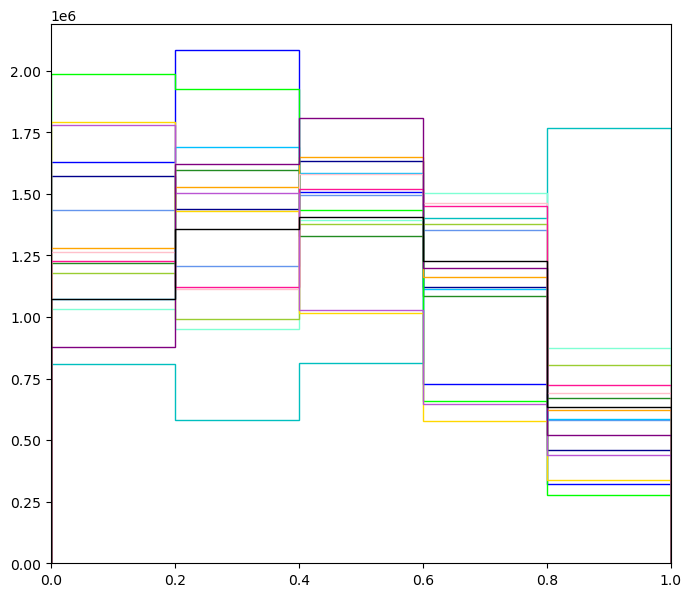

In [97]:
# create figure
fig, ax    = plt.subplots(nrows=1, ncols=1, figsize=[8,7],sharex=True, sharey=False, squeeze=True)

for model_name in model_names:
    # remove nan values
    # model_mask = ~ np.isnan(EF_input[model_name+'_EF'])
    hist = ax.hist(EF_input_new[model_name+'_EF'], bins=5, alpha=1., color=model_colors[model_name], label=model_name, histtype='step')
    ax.set_xlim(0, 1)
    fig.savefig(f"/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/plots/check_EF_pdf.png", bbox_inches='tight',dpi=300)

## Check daily EF

In [19]:
file_name   = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process2_output/EF_all_sites_1_day_mean.csv"
EF_input_1  = pd.read_csv(file_name, usecols=
                         ['model_CABLE', 'model_CABLE-POP-CN', 'model_CHTESSEL_Ref_exp1', 'model_CLM5a', 'model_GFDL',
                          'model_JULES_GL9', 'model_JULES_GL9_withLAI', 'model_MATSIRO', 'model_MuSICA', 'model_NASAEnt',
                          'model_NoahMPv401', 'model_ORC2_r6593', 'model_ORC3_r8120', 'model_QUINCY', 'model_STEMMUS-SCOPE','obs'])

### Check why daily EF > 1 or EF < 0

In [5]:
site_names, IGBP_types, clim_types, model_names = load_default_list()
model_names = model_names['model_select_new']
file_name   = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_all_sites.csv"
Qle_input   = pd.read_csv(file_name, usecols=
                         ['model_CABLE', 'model_CABLE-POP-CN', 'model_CHTESSEL_Ref_exp1', 'model_CLM5a', 'model_GFDL',
                          'model_JULES_GL9', 'model_JULES_GL9_withLAI', 'model_MATSIRO', 'model_MuSICA', 'model_NASAEnt',
                          'model_NoahMPv401', 'model_ORC2_r6593', 'model_ORC3_r8120', 'model_QUINCY', 'model_STEMMUS-SCOPE','obs'])

In [6]:
file_name   = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qh_all_sites.csv"
Qh_input    = pd.read_csv(file_name, usecols=
                         ['model_CABLE', 'model_CABLE-POP-CN', 'model_CHTESSEL_Ref_exp1', 'model_CLM5a', 'model_GFDL',
                          'model_JULES_GL9', 'model_JULES_GL9_withLAI', 'model_MATSIRO', 'model_MuSICA', 'model_NASAEnt',
                          'model_NoahMPv401', 'model_ORC2_r6593', 'model_ORC3_r8120', 'model_QUINCY', 'model_STEMMUS-SCOPE','obs'])

In [52]:
EF_input_1 = EF_input_1[mask_out]

8254506

In [ ]:
EF_input_1

In [12]:
np.any((EF_input_1['model_CABLE'] <0) & ((Qle_input['model_CABLE']< 0)|(Qh_input['model_CABLE']< 0)) )

True

In [85]:
np.sum((EF_input_1['model_CABLE'] <1) & (EF_input_1['model_CABLE'] >0))

14174845

In [86]:
np.sum((EF_input_1['model_CABLE'] <0) & (EF_input_1['model_CABLE'] >-1))

1084762

In [87]:
np.sum((EF_input_1['model_CABLE'] <-1) & (EF_input_1['model_CABLE'] >-2))

172587

### Calculate common data points

In [22]:
EF_input_1

,model_CABLE,model_CABLE-POP-CN,model_CHTESSEL_Ref_exp1,model_CLM5a,model_GFDL,model_JULES_GL9,model_JULES_GL9_withLAI,model_MATSIRO,model_MuSICA,model_NASAEnt,model_NoahMPv401,model_ORC2_r6593,model_ORC3_r8120,model_QUINCY,model_STEMMUS-SCOPE,obs
0,0.499109,0.374241,0.518373,0.409463,0.661298,0.379768,0.437581,0.404794,0.326481,0.340965,0.366452,0.317503,0.340495,0.172636,0.676387,0.573836
1,0.499109,0.374241,0.518373,0.409463,0.661298,0.379768,0.437581,0.404794,0.326481,0.340965,0.366452,0.317503,0.340495,0.172636,0.676387,0.573836
2,0.499109,0.374241,0.518373,0.409463,0.661298,0.379768,0.437581,0.404794,0.326481,0.340965,0.366452,0.317503,0.340495,0.172636,0.676387,0.573836
3,0.499109,0.374241,0.518373,0.409463,0.661298,0.379768,0.437581,0.404794,0.326481,0.340965,0.366452,0.317503,0.340495,0.172636,0.676387,0.573836
4,0.499109,0.374241,0.518373,0.409463,0.661298,0.379768,0.437581,0.404794,0.326481,0.340965,0.366452,0.317503,0.340495,0.172636,0.676387,0.573836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17137987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17137988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17137989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17137990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
model_names = ['model_CABLE', 'model_CABLE-POP-CN', 'model_CHTESSEL_Ref_exp1', 'model_CLM5a', 'model_GFDL',
               'model_JULES_GL9', 'model_JULES_GL9_withLAI', 'model_MATSIRO', 'model_MuSICA', 'model_NASAEnt',
               'model_NoahMPv401', 'model_ORC2_r6593', 'model_ORC3_r8120', 'model_QUINCY', 'model_STEMMUS-SCOPE','obs']

In [23]:
for model_name in model_names:
    EF_input_1.loc[:,model_name] = np.where( EF_input_1[model_name].values<0, np.nan,  EF_input_1[model_name].values)
    EF_input_1.loc[:,model_name] = np.where( EF_input_1[model_name].values< 0.2, 0.1,  EF_input_1[model_name].values)
    EF_input_1.loc[:,model_name] = np.where( EF_input_1[model_name].values< 0.4, 0.3,  EF_input_1[model_name].values)
    EF_input_1.loc[:,model_name] = np.where( EF_input_1[model_name].values< 0.6, 0.5,  EF_input_1[model_name].values)
    EF_input_1.loc[:,model_name] = np.where( EF_input_1[model_name].values< 0.8, 0.7,  EF_input_1[model_name].values)
    EF_input_1.loc[:,model_name] = np.where( EF_input_1[model_name].values<=1.0, 0.9,  EF_input_1[model_name].values)
    EF_input_1.loc[:,model_name] = np.where( EF_input_1[model_name].values>1.0, np.nan,EF_input_1[model_name].values)

In [24]:
EF_input_1

,model_CABLE,model_CABLE-POP-CN,model_CHTESSEL_Ref_exp1,model_CLM5a,model_GFDL,model_JULES_GL9,model_JULES_GL9_withLAI,model_MATSIRO,model_MuSICA,model_NASAEnt,model_NoahMPv401,model_ORC2_r6593,model_ORC3_r8120,model_QUINCY,model_STEMMUS-SCOPE,obs
0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
4,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17137987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17137988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17137989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17137990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Create the new column based on the comparison
EF_input_1['all_model_same'] = EF_input_1[model_names].apply(lambda row: row[0] if (row == row[0]).all() else np.nan, axis=1)


/jobfs/118638244.gadi-pbs/ipykernel_3126672/2001373966.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  EF_input_1['all_model_same'] = EF_input_1[model_names].apply(lambda row: row[0] if (row == row[0]).all() else np.nan, axis=1)


KeyError: 'model_all_model_same'

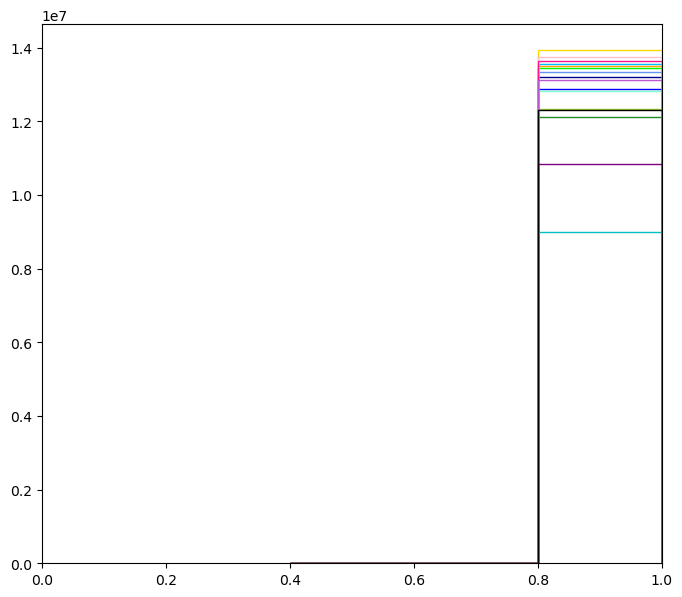

In [28]:
# create figure
fig, ax    = plt.subplots(nrows=1, ncols=1, figsize=[8,7],sharex=True, sharey=False, squeeze=True)

for model_name in model_names:
    if model_name == 'obs':
        head = ''
    else: 
        head = 'model_'
    # remove nan values
    model_mask = (EF_input_1[head+model_name] > 0) & (EF_input_1[head+model_name] < 1.) 
    hist = ax.hist(EF_input_1.loc[model_mask, head+model_name], bins=5, alpha=1., color=model_colors[model_name], label=model_name, histtype='step')
    # hist = ax.plot(EF_input_1[head+model_name].rolling(window=50000, min_periods=1).mean(), alpha=1., color=model_colors[model_name], label=model_name)
    ax.set_xlim(0, 1)
    # ax.set_ylim(-100, 200)
    # fig.savefig(f"/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/plots/check_EF_pdf.png", bbox_inches='tight',dpi=300)

# Check 5-day smoothing EF

In [19]:
file_name = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process2_output/EF_all_sites_5_day_mean.csv"
EF_input_5  = pd.read_csv(file_name, usecols=
                         ['model_CABLE', 'model_CABLE-POP-CN', 'model_CHTESSEL_Ref_exp1', 'model_CLM5a', 'model_GFDL',
                          'model_JULES_GL9', 'model_JULES_GL9_withLAI', 'model_MATSIRO', 'model_MuSICA', 'model_NASAEnt',
                          'model_NoahMPv401', 'model_ORC2_r6593', 'model_ORC3_r8120', 'model_QUINCY', 'model_STEMMUS-SCOPE','obs'])

In [ ]:
EF_low   = 0
EF_high  = 0.3

fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=[10,10],sharex=True, sharey=False, squeeze=True)

for model_name in model_names:
    mask = (EF_day[model_name+'_EF']>EF_low) & (EF_day[model_name+'_EF']<EF_high)
    hist = ax.hist(EF_day.loc[mask, 'hour'], bins=23, alpha=1., color=model_colors[model_name], label=model_name, histtype='step')
    
    # print(model_name,EF_day.loc[mask, 'hour'])
    ax.set_xlim(0,23)
    ax.set_xticks(np.arange(0,24,1))
fig.savefig('./Fig_curves_EF_0_0.3_hours_PDF.png',bbox_inches='tight',dpi=300) # '_30percent'


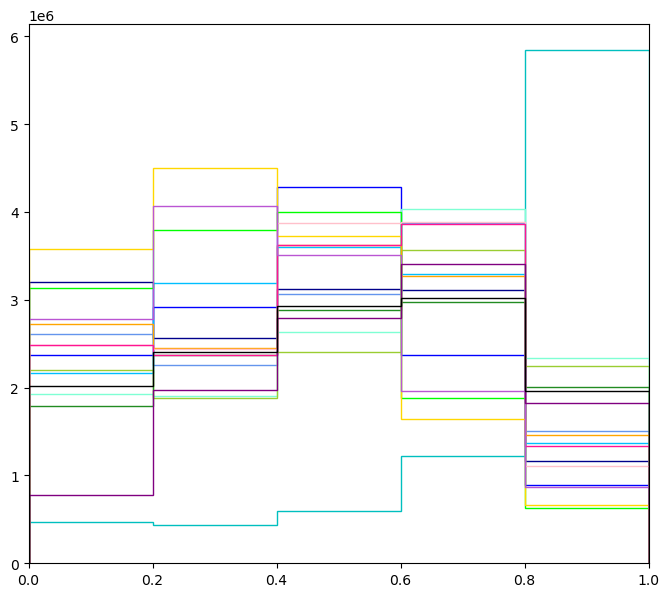

In [20]:
# create figure
fig, ax    = plt.subplots(nrows=1, ncols=1, figsize=[8,7],sharex=True, sharey=False, squeeze=True)

for model_name in model_names:
    if model_name == 'obs':
        head = ''
    else: 
        head = 'model_'
    # remove nan values
    model_mask = (EF_input_5[head+model_name] > 0) & (EF_input_5[head+model_name] < 1.) 
    hist = ax.hist(EF_input_5.loc[model_mask, head+model_name], bins=5, alpha=1., color=model_colors[model_name], label=model_name, histtype='step')
    ax.set_xlim(0, 1)

# Check missed SM files

In [8]:
site_names, IGBP_types, clim_types, model_names = load_default_list()

In [5]:
for site_name in site_names[:171]:
    # print(site_name)
    file_path = f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process2_output/SMtop0.5m_percentile_sites/SMtop0.5m_percentile_{site_name}.csv'

    try:
        SM_input  = pd.read_csv(file_path)
    except:
        print(site_name,'does not exist')

US-NR1 does not exist
